In [24]:
from fredapi import Fred

# Initialize with your API key
fred = Fred(api_key="5e5d96a6be5ff1469e7da93e5fb148b7")

In [25]:
import numpy as np
import pandas as pd

# 2. Define your FRED series list (like in MATLAB)
series = ["GDPC1", "UNRATE", "FEDFUNDS"]  # add whichever FRED series you want

# 3. Fetch the data from FRED and combine into a DataFrame
FRED = pd.concat({s: fred.get_series(s) for s in series}, axis=1)

# 4. Identify which series to transform (everything except FEDFUNDS)
trnsfrmIdx = [s != "FEDFUNDS" for s in series]
cols_to_transform = [s for s, t in zip(series, trnsfrmIdx) if t]

# 5. Apply log transform * 100, just like MATLAB's varfun(@(x)100*log(x))
Data = np.log(FRED[cols_to_transform]) * 100
Data = Data.rename(columns={s: s for s in cols_to_transform})

# 6. Add the untransformed FEDFUNDS column back
Data["FEDFUNDS"] = FRED["FEDFUNDS"]

# 7. Get the number of dimensions (columns)
numDims = Data.shape[1]

print(Data.head())
print(f"Number of dimensions: {numDims}")

                 GDPC1      UNRATE  FEDFUNDS
1947-01-01  768.830922         NaN       NaN
1947-04-01  768.565345         NaN       NaN
1947-07-01  768.360256         NaN       NaN
1947-10-01  769.914107         NaN       NaN
1948-01-01  771.408917  122.377543       NaN
Number of dimensions: 3


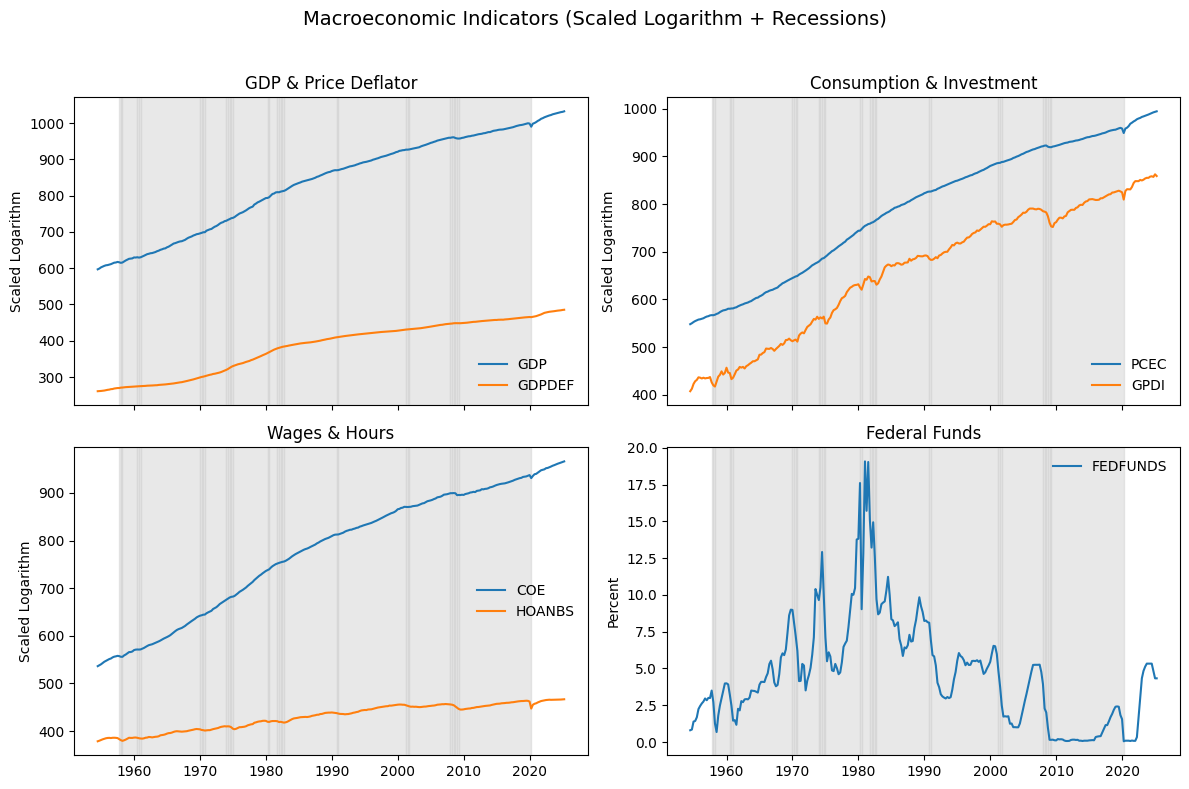

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fredapi import Fred


# --- 2. Define and download all series ---
series = ["GDP", "GDPDEF", "PCEC", "GPDI", "COE", "HOANBS", "FEDFUNDS", "USREC"]
data = {s: fred.get_series(s) for s in series}
Data = pd.DataFrame(data)

# Align and clean up
Data = Data.dropna(how="any")
Data.index.name = "Date"

# --- 3. Setup figure ---
fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
fig.suptitle("Macroeconomic Indicators (Scaled Logarithm + Recessions)", fontsize=14)

# Helper function: add recession shading
def recessionplot(ax, rec_series):
    rec = rec_series[rec_series == 1]
    for start, end in zip(rec.index, rec.index[1:]):
        # Only shade contiguous recession intervals
        if (end - start).days > 31:  # small filter for noise
            ax.axvspan(start, end, color="lightgray", alpha=0.5)

# --- 4. Subplots ---
# (1) GDP & GDP Deflator
ax = axs[0, 0]
ax.plot(Data.index, np.log(Data["GDP"]) * 100, label="GDP")
ax.plot(Data.index, np.log(Data["GDPDEF"]) * 100, label="GDPDEF")
recessionplot(ax, Data["USREC"])
ax.set_title("GDP & Price Deflator")
ax.set_ylabel("Scaled Logarithm")
ax.legend(frameon=False)

# (2) Consumption & Investment
ax = axs[0, 1]
ax.plot(Data.index, np.log(Data["PCEC"]) * 100, label="PCEC")
ax.plot(Data.index, np.log(Data["GPDI"]) * 100, label="GPDI")
recessionplot(ax, Data["USREC"])
ax.set_title("Consumption & Investment")
ax.set_ylabel("Scaled Logarithm")
ax.legend(frameon=False)

# (3) Wages & Hours
ax = axs[1, 0]
ax.plot(Data.index, np.log(Data["COE"]) * 100, label="COE")
ax.plot(Data.index, np.log(Data["HOANBS"]) * 100, label="HOANBS")
recessionplot(ax, Data["USREC"])
ax.set_title("Wages & Hours")
ax.set_ylabel("Scaled Logarithm")
ax.legend(frameon=False)

# (4) Federal Funds
ax = axs[1, 1]
ax.plot(Data.index, Data["FEDFUNDS"], label="FEDFUNDS")
recessionplot(ax, Data["USREC"])
ax.set_title("Federal Funds")
ax.set_ylabel("Percent")
ax.legend(frameon=False)

# --- 5. Layout ---
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [27]:
!pip install seaborn statsmodels

In [28]:
# Define the macroeconomic series
series = ["GDP", "GDPDEF", "COE", "HOANBS", "FEDFUNDS", "PCEC", "GPDI", "USREC"]
data = {s: fred.get_series(s) for s in series}
Data = pd.DataFrame(data).dropna()
Data.index.name = "Date"

In [29]:
# Apply 100*log(x) to all except FEDFUNDS (interest rate stays raw)
to_transform = [s for s in series if s not in ["FEDFUNDS", "USREC"]]
Data[to_transform] = np.log(Data[to_transform]) * 100

numDims = len(to_transform) + 1
print(f"Transformed dataset has {numDims} dimensions.")


Transformed dataset has 7 dimensions.


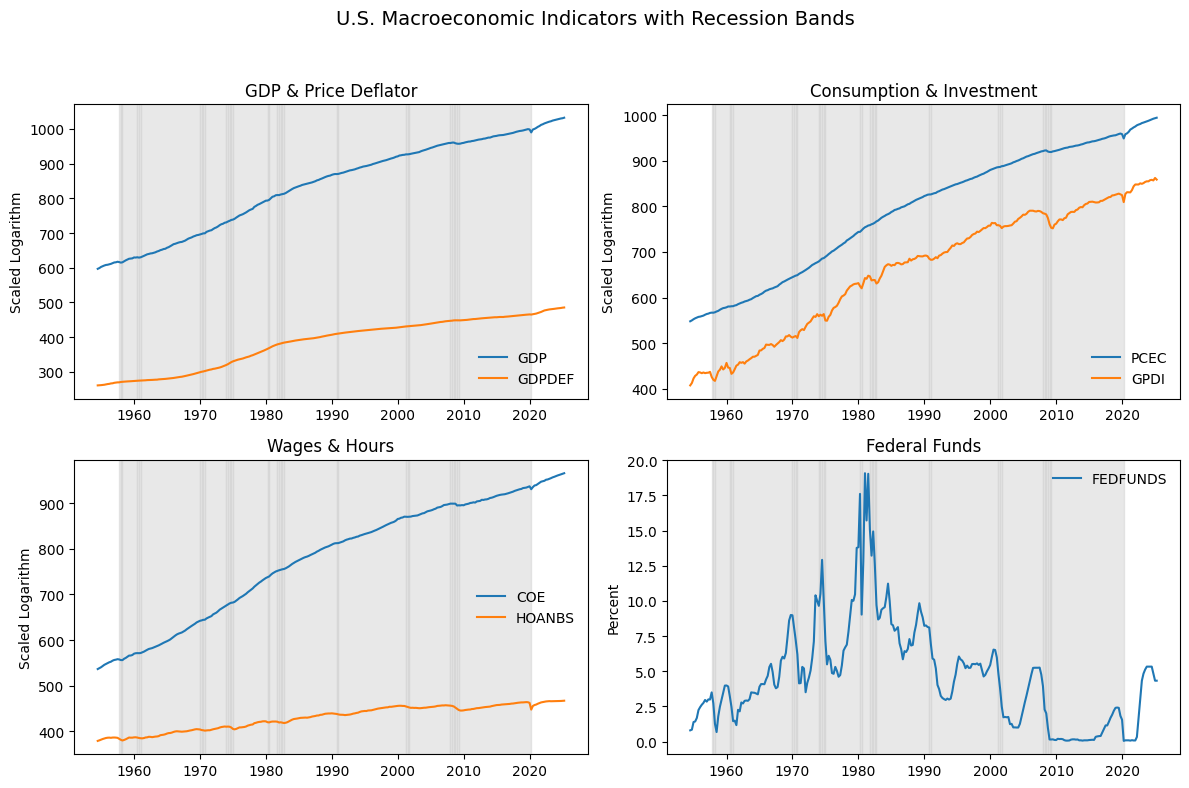

In [30]:
def recessionplot(ax, rec):
    """Shade recession periods using USREC series (1=recession)"""
    rec_periods = rec[rec == 1]
    for start, end in zip(rec_periods.index, rec_periods.index[1:]):
        if (end - start).days > 31:
            ax.axvspan(start, end, color="lightgray", alpha=0.5)

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("U.S. Macroeconomic Indicators with Recession Bands", fontsize=14)

pairs = [
    (["GDP", "GDPDEF"], "GDP & Price Deflator", "Scaled Logarithm"),
    (["PCEC", "GPDI"], "Consumption & Investment", "Scaled Logarithm"),
    (["COE", "HOANBS"], "Wages & Hours", "Scaled Logarithm"),
    (["FEDFUNDS"], "Federal Funds", "Percent")
]

for ax, (cols, title, ylabel) in zip(axs.ravel(), pairs):
    for c in cols:
        ax.plot(Data.index, Data[c], label=c)
    recessionplot(ax, Data["USREC"])
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.legend(frameon=False)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [31]:
import numpy as np
import pandas as pd
from fredapi import Fred
from statsmodels.tsa.vector_ar.vecm import coint_johansen, VECM
import matplotlib.pyplot as plt

# --- 2. Define and fetch series ---
series = ["GDP", "GDPDEF", "COE", "HOANBS", "PCEC", "GPDI", "FEDFUNDS"]
data = {s: fred.get_series(s) for s in series}
Data = pd.DataFrame(data).dropna()
Data.index.name = "Date"

# --- 3. Transform series ---
to_transform = [s for s in series if s != "FEDFUNDS"]
Data[to_transform] = np.log(Data[to_transform]) * 100

# --- 4. Johansen Cointegration Test ---
# det_order=1 → H1 model (unrestricted constant)
# k_ar_diff=1 → 2 lags in levels = 1 lag in differences
result = coint_johansen(Data, det_order=1, k_ar_diff=1)

# --- 5. Display test results ---
print("Trace Statistics vs 95% Critical Values:")
for i, (stat, crit) in enumerate(zip(result.lr1, result.cvt[:, 1])):
    print(f"r ≤ {i}: trace={stat:.2f}, crit_95={crit:.2f}")

# --- 6. Fit a VECM using the detected rank (say r=4) ---
vecm = VECM(Data, k_ar_diff=1, coint_rank=4, deterministic="co")
vecm_res = vecm.fit()

print("\nSummary of fitted VECM:")
print(vecm_res.summary())


Trace Statistics vs 95% Critical Values:
r ≤ 0: trace=211.47, crit_95=139.28
r ≤ 1: trace=116.47, crit_95=107.34
r ≤ 2: trace=69.45, crit_95=79.34
r ≤ 3: trace=32.36, crit_95=55.25
r ≤ 4: trace=17.49, crit_95=35.01
r ≤ 5: trace=6.33, crit_95=18.40
r ≤ 6: trace=0.48, crit_95=3.84

Summary of fitted VECM:
Det. terms outside the coint. relation & lagged endog. parameters for equation GDP
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           9.8522      8.114      1.214      0.225      -6.050      25.755
L1.GDP         -0.5434      0.205     -2.650      0.008      -0.945      -0.141
L1.GDPDEF       0.2754      0.182      1.509      0.131      -0.082       0.633
L1.COE          0.0547      0.116      0.469      0.639      -0.174       0.283
L1.HOANBS      -0.3727      0.112     -3.327      0.001      -0.592      -0.153
L1.PCEC         0.6732      0.164      4.108      0.

/home/david/Research/Economics/AEF/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


/home/david/Research/Economics/AEF/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


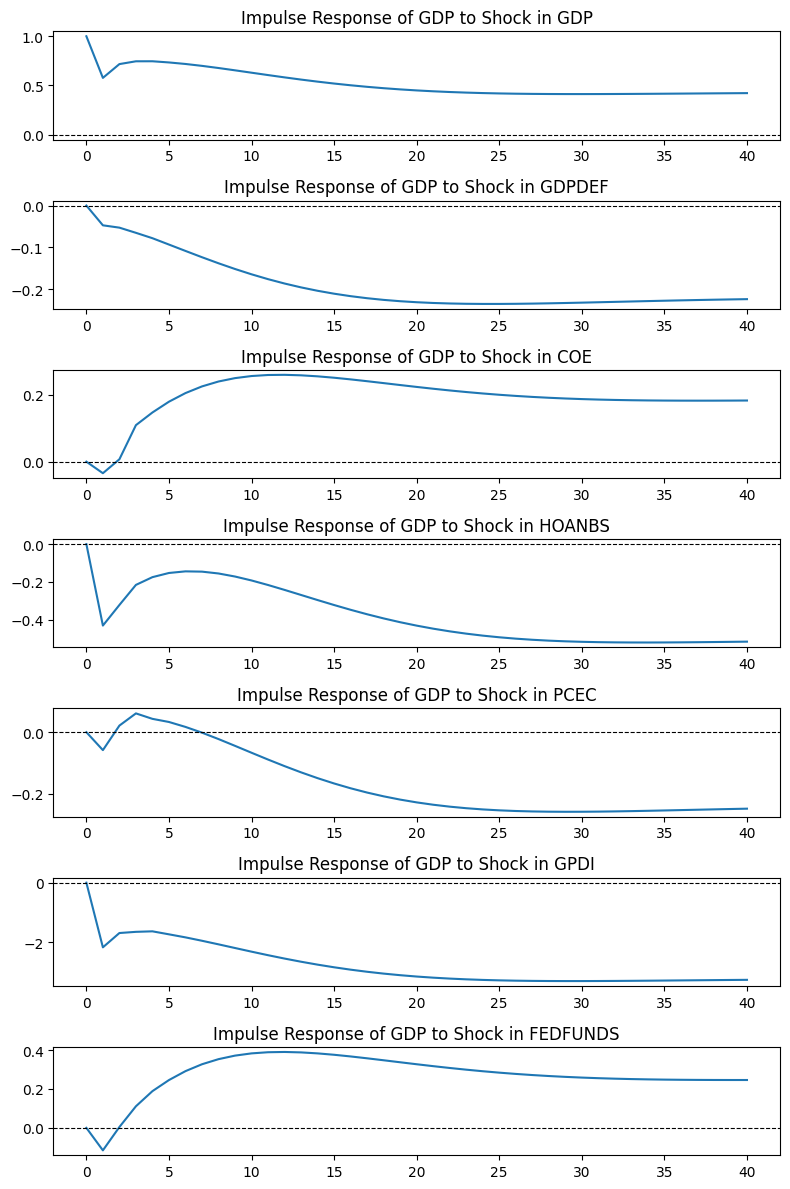

In [32]:
import matplotlib.pyplot as plt

# Fit VECM with chosen rank (Johansen suggests 3 here)
vecm = VECM(Data, k_ar_diff=1, coint_rank=3, deterministic="co")
vecm_res = vecm.fit()

# Compute impulse responses (40 quarters ahead)
irf = vecm_res.irf(40)

# Plot GDP response to shocks in all variables
fig, axes = plt.subplots(len(Data.columns), 1, figsize=(8, 12))
for i, var in enumerate(Data.columns):
    axes[i].plot(irf.irfs[:, i, 0])  # GDP is assumed to be the first variable
    axes[i].set_title(f"Impulse Response of GDP to Shock in {var}")
    axes[i].axhline(0, color="black", linewidth=0.8, linestyle="--")
plt.tight_layout()
plt.show()


In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assume:
#   vecm_res = fitted VECMResults object
#   Data = same DataFrame used for fitting
h = 4  # forecast horizon in quarters

# --- Try the modern call first; fall back if TypeError ---
try:
    fc = vecm_res.predict(steps=h)
except TypeError:
    fc = vecm_res.predict(steps=h, y=Data.values)

# Build forecast DataFrame
forecast_idx = pd.date_range(Data.index[-1], periods=h + 1, freq="Q")[1:]
forecast_df = pd.DataFrame(fc, columns=Data.columns, index=forecast_idx)

# Compute "real GDP" (nominal GDP - GDP deflator)
realGDP_forecast = forecast_df["GDP"] - forecast_df["GDPDEF"]
realGDP_actual = Data["GDP"].iloc[-h:] - Data["GDPDEF"].iloc[-h:]

# --- Plot ---
plt.figure(figsize=(10, 6))
plt.plot(realGDP_forecast.index, realGDP_forecast,

SyntaxError: incomplete input (694506734.py, line 26)

In [40]:
# Load the core macroeconomic series
series = ["GDP", "GDPDEF", "COE", "HOANBS", "PCEC", "GPDI", "FEDFUNDS"]
FRED = pd.concat({s: fred.get_series(s) for s in series}, axis=1).dropna()
FRED.index.name = "Date"

# Transform all except FEDFUNDS
for s in series:
    if s != "FEDFUNDS":
        FRED[s] = np.log(FRED[s]) * 100

In [41]:
# Johansen test to determine rank r
result = coint_johansen(FRED, det_order=1, k_ar_diff=1)
trace_stats = pd.DataFrame({
    "r": range(len(result.lr1)),
    "trace_stat": result.lr1,
    "crit_95": result.cvt[:, 1]
})
print(trace_stats)


   r  trace_stat   crit_95
0  0  211.470736  139.2780
1  1  116.473377  107.3429
2  2   69.447651   79.3422
3  3   32.355871   55.2459
4  4   17.486516   35.0116
5  5    6.328308   18.3985
6  6    0.480324    3.8415


In [42]:
P = 2   # lag order
r = 4   # cointegration rank
vecm = VECM(FRED, k_ar_diff=P-1, coint_rank=r, deterministic="co")  # 'co' = constant outside cointegration
vecm_res = vecm.fit()

print(vecm_res.summary())


Det. terms outside the coint. relation & lagged endog. parameters for equation GDP
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           9.8522      8.114      1.214      0.225      -6.050      25.755
L1.GDP         -0.5434      0.205     -2.650      0.008      -0.945      -0.141
L1.GDPDEF       0.2754      0.182      1.509      0.131      -0.082       0.633
L1.COE          0.0547      0.116      0.469      0.639      -0.174       0.283
L1.HOANBS      -0.3727      0.112     -3.327      0.001      -0.592      -0.153
L1.PCEC         0.6732      0.164      4.108      0.000       0.352       0.994
L1.GPDI         0.1098      0.034      3.198      0.001       0.042       0.177
L1.FEDFUNDS     0.0508      0.066      0.773      0.440      -0.078       0.179
Det. terms outside the coint. relation & lagged endog. parameters for equation GDPDEF
                  coef    std e

/home/david/Research/Economics/AEF/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


In [44]:
import numpy as np
import pandas as pd
from statsmodels.tsa.vector_ar.vecm import VECM

P = 2   # lag order
r = 4   # cointegration rank

# Fit baseline unrestricted VECM
vecm = VECM(FRED, k_ar_diff=P-1, coint_rank=r, deterministic="co")
vecm_res = vecm.fit()
print(vecm_res.summary())


Det. terms outside the coint. relation & lagged endog. parameters for equation GDP
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           9.8522      8.114      1.214      0.225      -6.050      25.755
L1.GDP         -0.5434      0.205     -2.650      0.008      -0.945      -0.141
L1.GDPDEF       0.2754      0.182      1.509      0.131      -0.082       0.633
L1.COE          0.0547      0.116      0.469      0.639      -0.174       0.283
L1.HOANBS      -0.3727      0.112     -3.327      0.001      -0.592      -0.153
L1.PCEC         0.6732      0.164      4.108      0.000       0.352       0.994
L1.GPDI         0.1098      0.034      3.198      0.001       0.042       0.177
L1.FEDFUNDS     0.0508      0.066      0.773      0.440      -0.078       0.179
Det. terms outside the coint. relation & lagged endog. parameters for equation GDPDEF
                  coef    std e

/home/david/Research/Economics/AEF/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


In [45]:
A = vecm_res.alpha      # adjustment matrix  (num_endog × r)
G = vecm_res.gamma      # short-run matrix   (num_endog × num_endog*(P-1))


In [47]:
# List all public attributes and methods
dir(vecm_res)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_cache',
 '_chol_sigma_u',
 '_cov_sigma',
 '_delta_x',
 '_delta_y_1_T',
 '_make_conf_int',
 '_y_lag1',
 'alpha',
 'beta',
 'coint_rank',
 'conf_int_alpha',
 'conf_int_beta',
 'conf_int_det_coef',
 'conf_int_det_coef_coint',
 'conf_int_gamma',
 'const',
 'const_coint',
 'cov_params_default',
 'cov_params_wo_det',
 'cov_var_repr',
 'dates',
 'det_coef',
 'det_coef_coint',
 'deterministic',
 'exog',
 'exog_coefs',
 'exog_coint',
 'exog_coint_coefs',
 'first_season',
 'fittedvalues',
 'gamma',
 'irf',
 'k_ar',
 'lin_trend',
 'lin_trend_coint',
 'llf',
 'ma_rep',
 'model',
 'names',
 'neqs',
 'nobs',
 'orth_m

In [48]:
# adjustment matrix (α) and its t-statistics
alpha = vecm_res.alpha
t_alpha = vecm_res.tvalues_alpha

# short-run coefficients (Γ) and their t-statistics
gamma = vecm_res.gamma
t_gamma = vecm_res.tvalues_gamma

# deterministic coefficients (constant/trend, if any)
t_const = vecm_res.tvalues_det_coef
t_coint_const = vecm_res.tvalues_det_coef_coint


In [49]:
alpha_constrained = alpha.copy()
gamma_constrained = gamma.copy()

alpha_constrained[np.abs(t_alpha) < 2] = 0
gamma_constrained[np.abs(t_gamma) < 2] = 0

In [50]:
print("Alpha shape:", vecm_res.alpha.shape)
print("Gamma shape:", vecm_res.gamma.shape)
print("t_alpha shape:", vecm_res.tvalues_alpha.shape)
print("t_gamma shape:", vecm_res.tvalues_gamma.shape)

Alpha shape: (7, 4)
Gamma shape: (7, 7)
t_alpha shape: (7, 4)
t_gamma shape: (7, 7)


In [51]:
print("t_const:", vecm_res.tvalues_det_coef)
print("t_const_coint:", vecm_res.tvalues_det_coef_coint)

t_const: [[ 1.21427506]
 [ 3.66043381]
 [-0.7942711 ]
 [ 0.88773917]
 [ 2.55198925]
 [ 0.44844108]
 [-3.32700294]]
t_const_coint: []


In [52]:
# extract matrices and t-stats
alpha = vecm_res.alpha
gamma = vecm_res.gamma
t_alpha = vecm_res.tvalues_alpha
t_gamma = vecm_res.tvalues_gamma

# zero out insignificant coefficients
alpha_constrained = alpha.copy()
gamma_constrained = gamma.copy()
alpha_constrained[np.abs(t_alpha) < 2] = 0
gamma_constrained[np.abs(t_gamma) < 2] = 0


In [53]:
import numpy as np
import pandas as pd
from statsmodels.tsa.vector_ar.vecm import coint_johansen

# Assume FRED is a dataframe with columns:
# ['GDP', 'GDPDEF', 'COE', 'HOANBS', 'PCEC', 'GPDI', 'FEDFUNDS']
# and that you've already log-transformed the real series

P = 2          # lag length in levels
lags_diff = P-1

# H* model  → det_order=2  (constant inside & outside + trend inside)
res_Hstar = coint_johansen(FRED, det_order=2, k_ar_diff=lags_diff)

# H1 model → det_order=1  (constant outside only)
res_H1 = coint_johansen(FRED, det_order=1, k_ar_diff=lags_diff)

def summarize_johansen(result, label):
    tbl = pd.DataFrame({
        "r": range(result.lr1.size),
        "trace_stat": result.lr1,
        "crit_95": result.cvt[:,1],
        "eigval": result.eig
    })
    tbl["reject_5pct"] = tbl["trace_stat"] > tbl["crit_95"]
    print(f"\n--- Johansen Trace Test ({label}) ---")
    print(tbl.to_string(index=False))
    return tbl

tbl_Hstar = summarize_johansen(res_Hstar, "H*")
tbl_H1    = summarize_johansen(res_H1,    "H1")



--- Johansen Trace Test (H*) ---
 r  trace_stat  crit_95   eigval  reject_5pct
 0  226.168888      NaN 0.307945        False
 1  122.367404      NaN 0.149785        False
 2   76.608250      NaN 0.117370        False
 3   41.400682      NaN 0.052168        False
 4   26.291606      NaN 0.042031        False
 5   14.182645      NaN 0.031782        False
 6    5.074570      NaN 0.017834        False

--- Johansen Trace Test (H1) ---
 r  trace_stat  crit_95   eigval  reject_5pct
 0  211.470736 139.2780 0.285998         True
 1  116.473377 107.3429 0.153595         True
 2   69.447651  79.3422 0.123248        False
 3   32.355871  55.2459 0.051362        False
 4   17.486516  35.0116 0.038796        False
 5    6.328308  18.3985 0.020524        False
 6    0.480324   3.8415 0.001702        False


/tmp/ipykernel_206534/269706186.py:13: HypothesisTestWarning: Critical values are only available for a det_order of -1, 0, or 1.
  res_Hstar = coint_johansen(FRED, det_order=2, k_ar_diff=lags_diff)


In [54]:
from scipy.stats import chi2

r = 4
uLogL = res_Hstar.llr       # unrestricted (H*)
rLogL = res_H1.llr          # restricted  (H1)

stat = 2 * (uLogL - rLogL)
df = r                       # number of restrictions
p_value = 1 - chi2.cdf(stat, df)
crit_95 = chi2.ppf(0.95, df)

print("\n--- Likelihood-ratio test H* vs H1 ---")
print(f"χ² statistic = {stat:.4f}")
print(f"Critical (95%) = {crit_95:.4f}")
print(f"p-value = {p_value:.4f}")

if p_value < 0.05:
    print("Reject H1 → prefer unrestricted H* model")
else:
    print("Fail to reject H1 → restricted H1 model adequate")


AttributeError: 'JohansenTestResult' object has no attribute 'llr'

In [55]:
# List all attributes and methods for res_Hstar
dir(res_Hstar)


['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_cvm',
 '_cvt',
 '_eig',
 '_evec',
 '_ind',
 '_lr1',
 '_lr2',
 '_meth',
 '_r0t',
 '_rkt',
 'cvm',
 'cvt',
 'eig',
 'evec',
 'ind',
 'lr1',
 'lr2',
 'max_eig_stat',
 'max_eig_stat_crit_vals',
 'meth',
 'r0t',
 'rkt',
 'trace_stat',
 'trace_stat_crit_vals']

In [57]:
from statsmodels.tsa.vector_ar.vecm import VECM
from scipy.stats import chi2

r = 4          # chosen cointegration rank
P = 2          # lag order
# H* : linear trend inside the cointegration relation  → deterministic="lt"
vecm_Hstar = VECM(FRED, k_ar_diff=P-1, coint_rank=r, deterministic="lt").fit()

# H1 : constant only (no trend in the cointegrating relation) → deterministic="co"
vecm_H1 = VECM(FRED, k_ar_diff=P-1, coint_rank=r, deterministic="co").fit()

# log-likelihoods
uLogL = vecm_Hstar.llf      # unrestricted
rLogL = vecm_H1.llf         # restricted

# LR statistic and p-value
stat = 2 * (uLogL - rLogL)
df = r
p_value = 1 - chi2.cdf(stat, df)
crit_95 = chi2.ppf(0.95, df)

print(f"χ² statistic = {stat:.3f}")
print(f"Critical value (95%) = {crit_95:.3f}")
print(f"p-value = {p_value:.4f}")

if p_value < 0.05:
    print("Reject H1 → prefer the unrestricted H* model")
else:
    print("Fail to reject H1 → the restricted H1 model is adequate")


χ² statistic = -19.484
Critical value (95%) = 9.488
p-value = 1.0000
Fail to reject H1 → the restricted H1 model is adequate


/home/david/Research/Economics/AEF/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/home/david/Research/Economics/AEF/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


In [58]:
r = 4          # cointegrating rank from the trace test
P = 2          # lag order in levels (so one lag in differences)
numDims = FRED.shape[1]


In [59]:
from statsmodels.tsa.vector_ar.vecm import VECM
from scipy.stats import chi2

# H* : linear trend inside the cointegration relation
vecm_Hstar = VECM(FRED, k_ar_diff=P-1, coint_rank=r, deterministic="lt").fit()

# H1 : constant only, no trend in cointegration relation
vecm_H1 = VECM(FRED, k_ar_diff=P-1, coint_rank=r, deterministic="co").fit()

uLogL = vecm_Hstar.llf        # unrestricted model
rLogL = vecm_H1.llf           # restricted model

stat = 2 * (uLogL - rLogL)
df = r                        # number of restrictions
p_value = 1 - chi2.cdf(stat, df)
crit_95 = chi2.ppf(0.95, df)

print(f"χ² statistic = {stat:.4f}")
print(f"Critical value (95%) = {crit_95:.4f}")
print(f"p-value = {p_value:.4f}")

if p_value < 0.05:
    print("Reject H1 → prefer the unrestricted H* model")
else:
    print("Fail to reject H1 → restricted H1 model adequate")


χ² statistic = -19.4835
Critical value (95%) = 9.4877
p-value = 1.0000
Fail to reject H1 → restricted H1 model adequate


/home/david/Research/Economics/AEF/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/home/david/Research/Economics/AEF/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


In [60]:
jmdl = "H1"     # chosen Johansen parametric form


In [61]:
MdlBL = vecm(numDims,r,P-1);


TypeError: 'VECM' object is not callable

In [62]:
# Define the candidate model using the chosen parameters
MdlBL = VECM(FRED, k_ar_diff=P-1, coint_rank=r, deterministic="co")  # "co" = H1 form


/home/david/Research/Economics/AEF/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


In [63]:
vecm_res = MdlBL.fit()
print(vecm_res.summary())


Det. terms outside the coint. relation & lagged endog. parameters for equation GDP
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           9.8522      8.114      1.214      0.225      -6.050      25.755
L1.GDP         -0.5434      0.205     -2.650      0.008      -0.945      -0.141
L1.GDPDEF       0.2754      0.182      1.509      0.131      -0.082       0.633
L1.COE          0.0547      0.116      0.469      0.639      -0.174       0.283
L1.HOANBS      -0.3727      0.112     -3.327      0.001      -0.592      -0.153
L1.PCEC         0.6732      0.164      4.108      0.000       0.352       0.994
L1.GPDI         0.1098      0.034      3.198      0.001       0.042       0.177
L1.FEDFUNDS     0.0508      0.066      0.773      0.440      -0.078       0.179
Det. terms outside the coint. relation & lagged endog. parameters for equation GDPDEF
                  coef    std e

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.vecm import VECM

# Cointegration rank, lag order, and chosen Johansen model
r = 4
P = 2
jmdl = "H1"  # "H1" corresponds to deterministic="co" (constant outside cointegration)

# Fit baseline unrestricted model
vecm_bl = VECM(FRED, k_ar_diff=P-1, coint_rank=r, deterministic="co").fit()
print(vecm_bl.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation GDP
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           9.8522      8.114      1.214      0.225      -6.050      25.755
L1.GDP         -0.5434      0.205     -2.650      0.008      -0.945      -0.141
L1.GDPDEF       0.2754      0.182      1.509      0.131      -0.082       0.633
L1.COE          0.0547      0.116      0.469      0.639      -0.174       0.283
L1.HOANBS      -0.3727      0.112     -3.327      0.001      -0.592      -0.153
L1.PCEC         0.6732      0.164      4.108      0.000       0.352       0.994
L1.GPDI         0.1098      0.034      3.198      0.001       0.042       0.177
L1.FEDFUNDS     0.0508      0.066      0.773      0.440      -0.078       0.179
Det. terms outside the coint. relation & lagged endog. parameters for equation GDPDEF
                  coef    std e

/home/david/Research/Economics/AEF/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


In [72]:
Mdl.Constant(abs(t) < 2) == 0;
Mdl.ShortRun[1](abs(t) < 2) == 0;
Mdl.Adjustment(abs(t) < 2) == 0;

NameError: name 'Mdl' is not defined

In [71]:
# Extract coefficients and t-values
alpha = vecm_bl.alpha
gamma = vecm_bl.gamma
const = vecm_bl.det_coef if hasattr(vecm_bl, "det_coef") else np.array([vecm_bl.params.const]).reshape(-1, 1)

t_alpha = vecm_bl.tvalues_alpha
t_gamma = vecm_bl.tvalues_gamma
t_const = vecm_bl.tvalues_det_coef

# Create constrained copies
alpha_c = alpha.copy()
gamma_c = gamma.copy()
const_c = const.copy()

alpha_c[np.abs(t_alpha) < 2] = 0
gamma_c[np.abs(t_gamma) < 2] = 0
const_c[np.abs(t_const) < 2] = 0

# Display summary of exclusions
print("Zeroed adjustment coefficients (alpha):", np.sum(alpha_c == 0))
print("Zeroed short-run coefficients (gamma):", np.sum(gamma_c == 0))
print("Zeroed constants:", np.sum(const_c == 0))


Zeroed adjustment coefficients (alpha): 11
Zeroed short-run coefficients (gamma): 25
Zeroed constants: 4


In [68]:
vecm_restricted = VECM(FRED, k_ar_diff=P-1, coint_rank=r, deterministic="co").fit()
print(vecm_restricted.summary())


Det. terms outside the coint. relation & lagged endog. parameters for equation GDP
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           9.8522      8.114      1.214      0.225      -6.050      25.755
L1.GDP         -0.5434      0.205     -2.650      0.008      -0.945      -0.141
L1.GDPDEF       0.2754      0.182      1.509      0.131      -0.082       0.633
L1.COE          0.0547      0.116      0.469      0.639      -0.174       0.283
L1.HOANBS      -0.3727      0.112     -3.327      0.001      -0.592      -0.153
L1.PCEC         0.6732      0.164      4.108      0.000       0.352       0.994
L1.GPDI         0.1098      0.034      3.198      0.001       0.042       0.177
L1.FEDFUNDS     0.0508      0.066      0.773      0.440      -0.078       0.179
Det. terms outside the coint. relation & lagged endog. parameters for equation GDPDEF
                  coef    std e

/home/david/Research/Economics/AEF/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


In [69]:
# Build the cointegration matrix B
beta = vecm_restricted.beta        # (r × numDims)
beta_const = vecm_restricted.det_coef_coint if hasattr(vecm_restricted, "det_coef_coint") else np.zeros((1, r))
beta_trend = np.zeros((1, r))      # No trend in H1 model

# Combine into [B; c0'; d0']
B = np.vstack([beta, beta_const, beta_trend])  # same shape as MATLAB stacking

# Construct data matrix [Y  1  t]
Y = FRED.values
t = np.arange(-(P - 1), Y.shape[0] - P).reshape(-1, 1)
X = np.hstack([Y, np.ones((Y.shape[0], 1)), t])

# Compute cointegrating relations
cointegrating_relations = X @ B

# Plot
plt.figure(figsize=(10, 6))
for i in range(cointegrating_relations.shape[1]):
    plt.plot(FRED.index, cointegrating_relations[:, i], label=f"Relation {i+1}")
plt.title("Cointegrating Relations")
plt.ylabel("Level")
plt.xlabel("Date")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 284 and the array at index 2 has size 283